In [9]:
!pip install rasterio segmentation-models-pytorch pytorch-lightning --upgrade

In [10]:
import os
import shutil
import glob
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from torch.optim import lr_scheduler
from matplotlib.colors import ListedColormap, BoundaryNorm
from tqdm import tqdm

In [11]:
class UNet_CD_Sentinel_2(pl.LightningModule):
    def __init__(self, encoder_name, classes, in_channels, learning_rate):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=None,
            classes=classes,
            in_channels=in_channels,
        )
        self.loss = torch.nn.CrossEntropyLoss()
        self.lr = learning_rate
        self.save_hyperparameters()
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")


        metrics = {
            f"{stage}_acuracia": accuracy,
            f"{stage}_dataset_iou": iou,
            f"{stage}_f1_score": f1_score,
        }

        self.log_dict(metrics, on_epoch=True)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        assert torch.isfinite(y_hat).all(), "Predições no treino contêm valores não finitos (NaN ou Inf)"

        loss = self.loss(y_hat, y)

        output = F.softmax(y_hat, dim=1)
        output = torch.argmax(output, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(
            output, y, mode="multiclass", num_classes=4
        )

        self.training_step_outputs.append(
            {
                "loss": loss,
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn,
            }
        )

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        assert torch.isfinite(y_hat).all(), "Predições na validação contêm valores não finitos (NaN ou Inf)"

        loss = self.loss(y_hat, y)

        output = F.softmax(y_hat, dim=1)
        output = torch.argmax(output, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(
            output, y, mode="multiclass", num_classes=4
        )

        self.validation_step_outputs.append(
            {
                "loss": loss,
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn,
            }
        )

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        assert torch.isfinite(y_hat).all(), "Predições no teste contêm valores não finitos (NaN ou Inf)"

        loss = self.loss(y_hat, y)

        output = F.softmax(y_hat, dim=1)
        output = torch.argmax(output, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(
            output, y, mode="multiclass", num_classes=4
        )

        self.test_step_outputs.append(
            {
                "loss": loss,
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn,
            }
        )

        self.log("test_loss", loss, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Define o scheduler para reduzir LR se a perda de validação não diminuir por 4 épocas
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=4, min_lr=1e-6, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",  # Monitora a perda de validação
                "interval": "epoch",  # Aplica o ajuste por época
                "frequency": 1,  # Frequência de monitoramento (1 = a cada época)
            },
        }


In [12]:
def get_image_paths(diretorio_base):
    # Listar arquivos de treino, validação e teste para as imagens de 512x512
    #train_files = glob.glob(
    #    diretorio_base + "train/*/*"
    #)
    #val_files = glob.glob(
    #    diretorio_base + "val/*/*"
    #)
    test_files = glob.glob(
        diretorio_base + "test/*/*"
    )

    # Criar DataFrames e adicionar a coluna 'set_type'
    #train_df = pd.DataFrame(train_files, columns=["file_path"])
    #train_df["set_type"] = "train"

    #val_df = pd.DataFrame(val_files, columns=["file_path"])
    #val_df["set_type"] = "val"

    test_df = pd.DataFrame(test_files, columns=["file_path"])
    test_df["set_type"] = "test"
    #df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    df = test_df

    print(f"Total de imagens: {len(df)}")
    return df

In [13]:
dataset_test = get_image_paths("/content/drive/MyDrive/CloudSen12/")

Total de imagens: 975


In [24]:
model_l1c_allbands_efficientnet = "/content/drive/MyDrive/Unet_all_bands_l1c/lightning_logs/Unet_efficientnet-b1/epoch=52-train_loss=0.22-val_loss=0.24-trainHigh512.ckpt"
model_l2a_4bands_efficientnet = "/content/drive/MyDrive/Unet_4_bands_l2a/lightning_logs/Unet_efficientnet-b1/epoch=45-train_loss=0.25-val_loss=0.27-trainHigh512.ckpt"

# Normalizar para exibição
def normalize(image):
  return ((image - image.min()) / (image.max() - image.min())*1.5).clip(0,1)

# Função para carregar o modelo
def load_model(model_path):
  model = UNet_CD_Sentinel_2.load_from_checkpoint(model_path)
  model.eval()  # Modo avaliação
  return model

# Função para passar a imagem pelo modelo
def predict(model, batch):
  device = next(model.parameters()).device
  with torch.no_grad():
      image_tensor = batch.to(device)  # Adiciona batch
      #print(image_tensor.shape)
      prediction = model(image_tensor)
      pr_masks = torch.argmax(prediction, dim=1)

  return pr_masks.to('cpu').squeeze().numpy()

def pad_image(image):
    """
    Adiciona padding a uma imagem multiespectral de 509x509 para 512x512.

    Parâmetros:
    - image (numpy.ndarray): Imagem com shape (Canais, 509, 509) ou (509, 509).

    Retorna:
    - numpy.ndarray: Imagem com shape (Canais, 512, 512) ou (512, 512).
    """
    if image.shape[-2:] != (509, 509):
        raise ValueError("A imagem deve ter dimensões 509x509.")

    pad_width = ((0, 0), (0, 3), (0, 3)) if image.ndim == 3 else ((0, 3), (0, 3))
    return np.pad(image, pad_width, mode='constant', constant_values=0)

def remove_padding(mask):
    """
    Remove o padding de uma máscara de 512x512 para restaurar o tamanho original 509x509.

    Parâmetros:
    - mask (numpy.ndarray): Máscara com shape (Canais, 512, 512) ou (512, 512).

    Retorna:
    - numpy.ndarray: Máscara com shape (Canais, 509, 509) ou (509, 509).
    """
    if mask.shape[-2:] != (512, 512):
        raise ValueError("A máscara deve ter dimensões 512x512.")

    return mask[..., :509, :509]  # Remove os últimos 3 pixels das dimensões espaciais

In [15]:
class CoreDataset(Dataset):
    def __init__(self, subset: pd.DataFrame, bandas, path_image):
      subset.reset_index(drop=True, inplace=True)
      self.subset = subset
      self.bandas = bandas
      self.path_image = path_image

    def __len__(self):
      return len(self.subset)

    def __getitem__(self, index: int):

      path = self.subset.iloc[index]["file_path"]
      s2_image = path + self.path_image
      mask = path + "/labels/manual_hq.tif"

      with rasterio.open(s2_image) as s2_file:
        s2_data = s2_file.read(self.bandas).astype(np.float32)/10000
        s2_data = pad_image(s2_data)

      with rasterio.open(mask) as mask_file:
        mask_data = mask_file.read(1).astype(np.int64)

      return s2_data, mask_data

dataset_l1c = CoreDataset(dataset_test, [1,2,3,4,5,6,7,8,9,10,11,12,13], "/S2L1C.tif")
dataset_l2a = CoreDataset(dataset_test, [2,3,4,8], "/S2L2A.tif")

dataloader_l1c = DataLoader(dataset_l1c, batch_size=16, shuffle=False, num_workers=8)
dataloader_l2a = DataLoader(dataset_l2a, batch_size=16, shuffle=False, num_workers=8)


# Metricas para Nuvem/Não Nuvem

In [ ]:
import numpy as np
# Lista para armazenar os resultados
resultados_cloud_no_cloud = []
def calculate_confusion_matrix_batch(y_pred, y_true):
    """
    Calcula TP, FP, FN e TN para um lote (batch) de imagens.

    Parâmetros:
    - y_pred (np.array): Máscaras preditas (shape: batch_size x H x W, valores binários 0 ou 1)
    - y_true (np.array): Máscaras verdadeiras (shape: batch_size x H x W, valores binários 0 ou 1)

    Retorna:
    - TP (np.array): True Positives por imagem no batch (shape: batch_size)
    - FP (np.array): False Positives por imagem no batch (shape: batch_size)
    - FN (np.array): False Negatives por imagem no batch (shape: batch_size)
    - TN (np.array): True Negatives por imagem no batch (shape: batch_size)
    """
    # Garantir que os arrays estão no formato correto
    y_pred = np.array(y_pred).astype(np.uint8)
    y_true = np.array(y_true).astype(np.uint8)

    # Cálculo por batch
    tp = np.sum((y_pred == 1) & (y_true == 1), axis=(1, 2))  # Soma sobre H e W
    fp = np.sum((y_pred == 1) & (y_true == 0), axis=(1, 2))
    fn = np.sum((y_pred == 0) & (y_true == 1), axis=(1, 2))
    tn = np.sum((y_pred == 0) & (y_true == 0), axis=(1, 2))

    return tp, fp, fn, tn

steps_outputs_metrics_model_l1c_multiclass = []
steps_outputs_metrics_model_l1c_binary = []
model = load_model(model_l1c_allbands_efficientnet)
for batch in tqdm(dataloader_l1c, desc="Calculando Métricas"):
  x, y = batch
  mask_l1c = predict(model, x)
  mask_l1c = remove_padding(mask_l1c)
  tp, fp, fn, tn = smp.metrics.get_stats(
      torch.from_numpy(mask_l1c.astype(np.int64)), y, mode="multiclass", num_classes=4)
  steps_outputs_metrics_model_l1c_multiclass.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
  mask_l1c[mask_l1c == 2] = 1
  mask_l1c[mask_l1c == 3] = 0
  y[y == 2] = 1
  y[y == 3] = 0

  tp, fp, fn, tn = calculate_confusion_matrix_batch(mask_l1c, y)
  steps_outputs_metrics_model_l1c_binary.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


tp = torch.cat([x["tp"] for x in steps_outputs_metrics_model_l1c_multiclass])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics_model_l1c_multiclass])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics_model_l1c_multiclass])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics_model_l1c_multiclass])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print("\n")
print("Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")

tp = torch.cat([torch.tensor(x["tp"], dtype=torch.float32) for x in steps_outputs_metrics_model_l1c_binary])
fp = torch.cat([torch.tensor(x["fp"], dtype=torch.float32) for x in steps_outputs_metrics_model_l1c_binary])
fn = torch.cat([torch.tensor(x["fn"], dtype=torch.float32) for x in steps_outputs_metrics_model_l1c_binary])
tn = torch.cat([torch.tensor(x["tn"], dtype=torch.float32) for x in steps_outputs_metrics_model_l1c_binary])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = sum(tp) / sum((tp + fn))
UA = sum(tp) / sum((tp + fp))
BOA = 0.5*((sum(tp) / sum((tp + fn))) + (sum(tn) / sum((tn + fp))))

resultados_cloud_no_cloud.append({
        "Modelo": "L1C 13 Bandas EfficientNet-B1",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print("\n")
print("Resultados Binario (Nuvem/Não Nuvem)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {PA*100:.2f}")
print(f"UA: {UA*100:.2f}")
print(f"BOA: {BOA*100:.2f}")

Calculando Métricas: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]



Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)
Acurácia no conjunto de teste: 95.12
IoU no conjunto de teste: 82.21
F1 no conjunto de teste: 90.23


Resultados Binario (Nuvem/Não Nuvem)
Acurácia no conjunto de teste: 94.17
IoU no conjunto de teste: 85.74
F1 no conjunto de teste: 92.33
PA: 91.27
UA: 93.40
BOA: 93.63


In [ ]:
steps_outputs_metrics_model_l2a_multiclass = []
steps_outputs_metrics_model_l2a_binary = []
model = load_model(model_l2a_4bands_efficientnet)
for batch in tqdm(dataloader_l2a, desc="Calculando Métricas"):
  x, y = batch
  mask_l2a = predict(model, x)
  mask_l2a = remove_padding(mask_l2a)
  tp, fp, fn, tn = smp.metrics.get_stats(
      torch.from_numpy(mask_l2a.astype(np.int64)), y, mode="multiclass", num_classes=4)
  steps_outputs_metrics_model_l2a_multiclass.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
  mask_l2a[mask_l2a == 2] = 1
  mask_l2a[mask_l2a == 3] = 0
  y[y == 2] = 1
  y[y == 3] = 0

  tp, fp, fn, tn = calculate_confusion_matrix_batch(mask_l2a, y)
  steps_outputs_metrics_model_l2a_binary.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


tp = torch.cat([x["tp"] for x in steps_outputs_metrics_model_l2a_multiclass])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics_model_l2a_multiclass])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics_model_l2a_multiclass])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics_model_l2a_multiclass])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print("\n")
print("Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")

fp = torch.cat([torch.tensor(x["fp"], dtype=torch.float32) for x in steps_outputs_metrics_model_l2a_binary])
fn = torch.cat([torch.tensor(x["fn"], dtype=torch.float32) for x in steps_outputs_metrics_model_l2a_binary])
tn = torch.cat([torch.tensor(x["tn"], dtype=torch.float32) for x in steps_outputs_metrics_model_l2a_binary])
tp = torch.cat([torch.tensor(x["tp"], dtype=torch.float32) for x in steps_outputs_metrics_model_l2a_binary])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = sum(tp) / sum((tp + fn))
UA = sum(tp) / sum((tp + fp))
BOA = 0.5*((sum(tp) / sum((tp + fn))) + (sum(tn) / sum((tn + fp))))

resultados_cloud_no_cloud.append({
        "Modelo": "L2A 4 Bandas EfficientNet-B1",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print("\n")
print("Resultados Binario (Nuvem/Não Nuvem)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {PA*100:.2f}")
print(f"UA: {UA*100:.2f}")
print(f"BOA: {BOA*100:.2f}")

Calculando Métricas: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]



Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)
Acurácia no conjunto de teste: 94.69
IoU no conjunto de teste: 80.80
F1 no conjunto de teste: 89.38


Resultados Binario (Nuvem/Não Nuvem)
Acurácia no conjunto de teste: 93.56
IoU no conjunto de teste: 84.30
F1 no conjunto de teste: 91.48
PA: 90.03
UA: 92.97
BOA: 92.90


In [ ]:
def calculate_confusion_matrix_image(y_pred, y_true):
    """
    Calcula TP, FP, FN e TN para uma única imagem.

    Parâmetros:
    - y_pred (np.array): Máscara predita (shape: H x W, valores binários 0 ou 1)
    - y_true (np.array): Máscara verdadeira (shape: H x W, valores binários 0 ou 1)

    Retorna:
    - TP (int): True Positives
    - FP (int): False Positives
    - FN (int): False Negatives
    - TN (int): True Negatives
    """
    # Garantir que os arrays estão no formato correto
    y_pred = np.array(y_pred).astype(np.uint8)
    y_true = np.array(y_true).astype(np.uint8)

    # Cálculo por imagem
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
    fp = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True Negatives

    return tp, fp, fn, tn


steps_outputs_metrics_model_sen2cor = []
steps_outputs_metrics_model_s2cloudless = []
steps_outputs_metrics_model_fmask = []
steps_outputs_metrics_model_kappamask_L1C = []
steps_outputs_metrics_model_kappamask_L2A = []
steps_outputs_metrics_model_CD_FCNN_RGBI = []
steps_outputs_metrics_model_CD_FCNN_RGBISWIR = []

for index in tqdm(range(len(dataset_test)), desc="Calculando Métricas"):

  path = dataset_test.iloc[index]["file_path"]

  mask = path + "/labels/manual_hq.tif"
  sen2cor = path + "/labels/sen2cor.tif"
  s2_cloudless = path + "/labels/s2cloudless.tif"
  fmask = path + "/labels/fmask.tif"
  kappamask_L1C = path + "/labels/kappamask_L1C.tif"
  kappamask_L2A = path + "/labels/kappamask_L2A.tif"
  CD_FCNN_RGBI = path +  "/labels/CD-FCNN-RGBI.tif"
  CD_FCNN_RGBISWIR = path +  "/labels/CD-FCNN-RGBISWIR.tif"

  with rasterio.open(mask) as mask_file:
    mask_data = mask_file.read(1)
    mask_data[mask_data == 2] = 1
    mask_data[mask_data == 3] = 0

  with rasterio.open(sen2cor) as sen2cor_file:
    sen2cor_data = sen2cor_file.read(1)
    # Criando uma cópia dos dados para modificar
    transformed_data = np.zeros_like(sen2cor_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[sen2cor_data == 9] = 1
    transformed_data[sen2cor_data == 8] = 1
    #transformed_data[sen2cor_data == 3] = 0
    sen2cor_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(sen2cor_data, mask_data)
  steps_outputs_metrics_model_sen2cor.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})

  with rasterio.open(s2_cloudless) as s2_cloudless_file:
    s2_cloudless_data = s2_cloudless_file.read(1).astype(np.float32)*0.01
    transformed_data = np.zeros_like(s2_cloudless_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[s2_cloudless_data > 0.4] = 1
    s2_cloudless_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(s2_cloudless_data, mask_data)
  steps_outputs_metrics_model_s2cloudless.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(fmask) as fmask_file:
    fmask_data = fmask_file.read(1)
    transformed_data = np.zeros_like(fmask_data)
    # Aplicando as transformações conforme solicitado
    #transformed_data[fmask_data == 2] = 3
    transformed_data[fmask_data == 4] = 1
    fmask_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(fmask_data, mask_data)
  steps_outputs_metrics_model_fmask.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(kappamask_L1C) as kappamask_L1C_file:
    kappamask_L1C_data = kappamask_L1C_file.read(1)
    transformed_data = np.zeros_like(kappamask_L1C_data)
    # Aplicando as transformações conforme solicitado
    #transformed_data[kappamask_L1C_data == 2] = 3
    transformed_data[kappamask_L1C_data == 3] = 1
    transformed_data[kappamask_L1C_data == 4] = 1
    kappamask_L1C_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(kappamask_L1C_data, mask_data)
  steps_outputs_metrics_model_kappamask_L1C.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(kappamask_L2A) as kappamask_L2A_file:
    kappamask_L2A_data = kappamask_L2A_file.read(1)
    transformed_data = np.zeros_like(kappamask_L2A_data)
    # Aplicando as transformações conforme solicitado
    #transformed_data[kappamask_L2A_data == 2] = 3
    transformed_data[kappamask_L2A_data == 3] = 1
    transformed_data[kappamask_L2A_data == 4] = 1
    kappamask_L2A_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(kappamask_L2A_data, mask_data)
  steps_outputs_metrics_model_kappamask_L2A.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(CD_FCNN_RGBI) as CD_FCNN_RGBI_file:
    CD_FCNN_RGBI_data = CD_FCNN_RGBI_file.read(1).astype(np.float32)*0.0001
    transformed_data = np.zeros_like(CD_FCNN_RGBI_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[CD_FCNN_RGBI_data > 0.5] = 1
    CD_FCNN_RGBI_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(CD_FCNN_RGBI_data, mask_data)
  steps_outputs_metrics_model_CD_FCNN_RGBI.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(CD_FCNN_RGBISWIR) as CD_FCNN_RGBISWIR_file:
    CD_FCNN_RGBISWIR_data = CD_FCNN_RGBISWIR_file.read(1).astype(np.float32)*0.0001
    transformed_data = np.zeros_like(CD_FCNN_RGBISWIR_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[CD_FCNN_RGBISWIR_data > 0.5] = 1
    CD_FCNN_RGBISWIR_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(CD_FCNN_RGBISWIR_data, mask_data)
  steps_outputs_metrics_model_CD_FCNN_RGBISWIR.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})



Calculando Métricas: 100%|██████████| 975/975 [01:06<00:00, 14.71it/s]


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in steps_outputs_metrics_model_sen2cor), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in steps_outputs_metrics_model_sen2cor), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in steps_outputs_metrics_model_sen2cor), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in steps_outputs_metrics_model_sen2cor), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_cloud_no_cloud.append({
        "Modelo": "Sen2Cor",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 80.64
IoU no conjunto de teste: 52.41
F1 no conjunto de teste: 68.78
PA: 55.52
UA: 90.35
BOA: 75.91


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in steps_outputs_metrics_model_s2cloudless), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in steps_outputs_metrics_model_s2cloudless), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in steps_outputs_metrics_model_s2cloudless), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in steps_outputs_metrics_model_s2cloudless), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_cloud_no_cloud.append({
        "Modelo": "S2Cloudless",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 86.33
IoU no conjunto de teste: 68.31
F1 no conjunto de teste: 81.17
PA: 76.73
UA: 86.16
BOA: 84.52


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in steps_outputs_metrics_model_fmask), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in steps_outputs_metrics_model_fmask), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in steps_outputs_metrics_model_fmask), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in steps_outputs_metrics_model_fmask), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_cloud_no_cloud.append({
        "Modelo": "Fmask",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 87.26
IoU no conjunto de teste: 71.66
F1 no conjunto de teste: 83.49
PA: 83.89
UA: 83.10
BOA: 86.63


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in steps_outputs_metrics_model_kappamask_L1C), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in steps_outputs_metrics_model_kappamask_L1C), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in steps_outputs_metrics_model_kappamask_L1C), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in steps_outputs_metrics_model_kappamask_L1C), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_cloud_no_cloud.append({
        "Modelo": "KappaMask_L1C",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 85.69
IoU no conjunto de teste: 69.38
F1 no conjunto de teste: 81.92
PA: 84.46
UA: 79.53
BOA: 85.45


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in steps_outputs_metrics_model_kappamask_L2A), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in steps_outputs_metrics_model_kappamask_L2A), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in steps_outputs_metrics_model_kappamask_L2A), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in steps_outputs_metrics_model_kappamask_L2A), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_cloud_no_cloud.append({
        "Modelo": "KappaMask_L2A",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 80.00
IoU no conjunto de teste: 63.08
F1 no conjunto de teste: 77.36
PA: 89.00
UA: 68.42
BOA: 81.69


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in steps_outputs_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in steps_outputs_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in steps_outputs_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in steps_outputs_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_cloud_no_cloud.append({
        "Modelo": "CD_FCNN_RGBI",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 80.52
IoU no conjunto de teste: 51.62
F1 no conjunto de teste: 68.09
PA: 54.13
UA: 91.76
BOA: 75.55


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in steps_outputs_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in steps_outputs_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in steps_outputs_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in steps_outputs_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_cloud_no_cloud.append({
        "Modelo": "CD_FCNN_RGBISWIR",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 81.48
IoU no conjunto de teste: 53.27
F1 no conjunto de teste: 69.52
PA: 55.00
UA: 94.43
BOA: 76.49


In [ ]:
# Criar DataFrame no final
df_resultados_cloud_no_cloud = pd.DataFrame(resultados_cloud_no_cloud)

df_resultados_cloud_no_cloud.iloc[:, 1:] = df_resultados_cloud_no_cloud.iloc[:, 1:].map(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
df_resultados_cloud_no_cloud.iloc[:, 1:] = df_resultados_cloud_no_cloud.iloc[:, 1:].map(lambda x: round(x.item() * 100, 2) if isinstance(x, torch.Tensor) else round(x * 100, 2))

df_resultados_cloud_no_cloud

,Modelo,Acurácia,IoU,F1,PA,UA,BOA
0,L1C 13 Bandas EfficientNet-B1,94.17,85.74,92.33,91.27,93.4,93.63
1,L2A 4 Bandas EfficientNet-B1,93.56,84.3,91.48,90.03,92.97,92.9
2,Sen2Cor,80.64,52.41,68.78,55.52,90.35,75.91
3,S2Cloudless,86.33,68.31,81.17,76.73,86.16,84.52
4,Fmask,87.26,71.66,83.49,83.89,83.1,86.63
5,KappaMask_L1C,85.69,69.38,81.92,84.46,79.53,85.45
6,KappaMask_L2A,80.0,63.08,77.36,89.0,68.42,81.69
7,CD_FCNN_RGBI,80.52,51.62,68.09,54.13,91.76,75.55
8,CD_FCNN_RGBISWIR,81.48,53.27,69.52,55.0,94.43,76.49


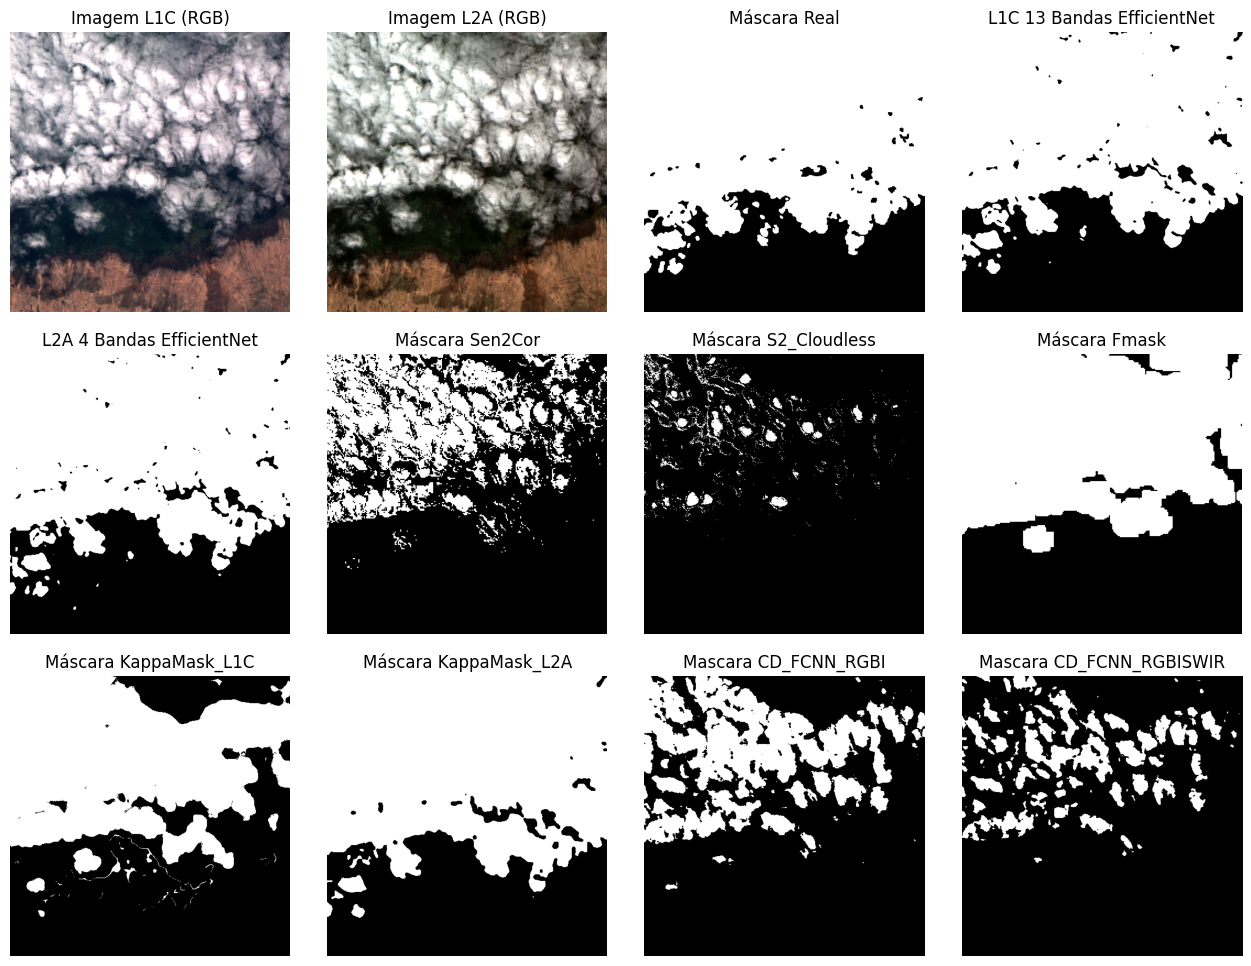

In [66]:
index = index + 1
path = dataset_test.iloc[index]["file_path"]

s2_l1c = path + "/S2L1C.tif"
s2_l2a = path + "/S2L2A.tif"

mask = path + "/labels/manual_hq.tif"
sen2cor = path + "/labels/sen2cor.tif"
s2_cloudless = path + "/labels/s2cloudless.tif"
fmask = path + "/labels/fmask.tif"
kappamask_L1C = path + "/labels/kappamask_L1C.tif"
kappamask_L2A = path + "/labels/kappamask_L2A.tif"
CD_FCNN_RGBI = path +  "/labels/CD-FCNN-RGBI.tif"
CD_FCNN_RGBISWIR = path +  "/labels/CD-FCNN-RGBISWIR.tif"

with rasterio.open(s2_l1c) as s2_l1c_file:
  s2_l1c_data = s2_l1c_file.read().astype(np.float32)/10000

with rasterio.open(s2_l2a) as s2_l2a_file:
  s2_l2a_data = s2_l2a_file.read([2,3,4,8]).astype(np.float32)/10000

model_l1c = load_model(model_l1c_allbands_efficientnet)
l1c_data = pad_image(s2_l1c_data)
mask_l1c = predict(model_l1c, torch.tensor(l1c_data).unsqueeze(0))
mask_l1c = remove_padding(mask_l1c)
mask_l1c[mask_l1c == 2] = 1
mask_l1c[mask_l1c == 3] = 0

model_l2a = load_model(model_l2a_4bands_efficientnet)
l2a_data = pad_image(s2_l2a_data)
mask_l2a = predict(model_l2a, torch.tensor(l2a_data).unsqueeze(0))
mask_l2a = remove_padding(mask_l2a)
mask_l2a[mask_l2a == 2] = 1
mask_l2a[mask_l2a == 3] = 0

with rasterio.open(mask) as mask_file:
  mask_data = mask_file.read(1)
  mask_data[mask_data == 2] = 1
  mask_data[mask_data == 3] = 0

with rasterio.open(sen2cor) as sen2cor_file:
  sen2cor_data = sen2cor_file.read(1)
  # Criando uma cópia dos dados para modificar
  transformed_data = np.zeros_like(sen2cor_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[sen2cor_data == 9] = 1
  transformed_data[sen2cor_data == 8] = 1
  #transformed_data[sen2cor_data == 3] = 0
  sen2cor_data = transformed_data

with rasterio.open(s2_cloudless) as s2_cloudless_file:
  s2_cloudless_data = s2_cloudless_file.read(1).astype(np.float32)*0.01
  transformed_data = np.zeros_like(s2_cloudless_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[s2_cloudless_data > 0.4] = 1
  s2_cloudless_data = transformed_data


with rasterio.open(fmask) as fmask_file:
  fmask_data = fmask_file.read(1)
  transformed_data = np.zeros_like(fmask_data)
  # Aplicando as transformações conforme solicitado
  #transformed_data[fmask_data == 2] = 3
  transformed_data[fmask_data == 4] = 1
  fmask_data = transformed_data


with rasterio.open(kappamask_L1C) as kappamask_L1C_file:
  kappamask_L1C_data = kappamask_L1C_file.read(1)
  transformed_data = np.zeros_like(kappamask_L1C_data)
  # Aplicando as transformações conforme solicitado
  #transformed_data[kappamask_L1C_data == 2] = 3
  transformed_data[kappamask_L1C_data == 3] = 1
  transformed_data[kappamask_L1C_data == 4] = 1
  kappamask_L1C_data = transformed_data


with rasterio.open(kappamask_L2A) as kappamask_L2A_file:
  kappamask_L2A_data = kappamask_L2A_file.read(1)
  transformed_data = np.zeros_like(kappamask_L2A_data)
  # Aplicando as transformações conforme solicitado
  #transformed_data[kappamask_L2A_data == 2] = 3
  transformed_data[kappamask_L2A_data == 3] = 1
  transformed_data[kappamask_L2A_data == 4] = 1
  kappamask_L2A_data = transformed_data


with rasterio.open(CD_FCNN_RGBI) as CD_FCNN_RGBI_file:
  CD_FCNN_RGBI_data = CD_FCNN_RGBI_file.read(1).astype(np.float32)*0.0001
  transformed_data = np.zeros_like(CD_FCNN_RGBI_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[CD_FCNN_RGBI_data > 0.5] = 1
  CD_FCNN_RGBI_data = transformed_data


with rasterio.open(CD_FCNN_RGBISWIR) as CD_FCNN_RGBISWIR_file:
  CD_FCNN_RGBISWIR_data = CD_FCNN_RGBISWIR_file.read(1).astype(np.float32)*0.0001
  transformed_data = np.zeros_like(CD_FCNN_RGBISWIR_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[CD_FCNN_RGBISWIR_data > 0.5] = 1
  CD_FCNN_RGBISWIR_data = transformed_data

# Definir as cores (valores de 0 a 3)
cores = ["black", "white", "yellow", "gray"]
cmap_custom = ListedColormap(cores)

# Criar uma normalização fixa para os valores 0, 1, 2, 3
norm = BoundaryNorm([0, 1, 2, 3, 4], cmap_custom.N)  # Define os intervalos das cores

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Remove espaços entre os subplots para melhor aproveitamento do espaço
plt.subplots_adjust(wspace=0.1, hspace=0.15)

axes[0, 0].imshow(normalize(np.dstack([s2_l1c_data[3], s2_l1c_data[2], s2_l1c_data[1]])))  # RGB falso L1C
axes[0, 0].set_title("Imagem L1C (RGB)")

axes[0, 1].imshow(normalize(np.dstack([s2_l2a_data[2], s2_l2a_data[1], s2_l2a_data[0]])))  # RGB falso L2A
axes[0, 1].set_title("Imagem L2A (RGB)")

axes[0, 2].imshow(mask_data, cmap=cmap_custom, norm=norm)
axes[0, 2].set_title("Máscara Real")

axes[0, 3].imshow(mask_l1c, cmap=cmap_custom, norm=norm)
axes[0, 3].set_title("L1C 13 Bandas EfficientNet")

axes[1, 0].imshow(mask_l2a, cmap=cmap_custom, norm=norm)
axes[1, 0].set_title("L2A 4 Bandas EfficientNet")

axes[1, 1].imshow(sen2cor_data, cmap=cmap_custom, norm=norm)
axes[1, 1].set_title("Máscara Sen2Cor")

axes[1, 2].imshow(s2_cloudless_data, cmap=cmap_custom, norm=norm)
axes[1, 2].set_title("Máscara S2_Cloudless")

axes[1, 3].imshow(fmask_data, cmap=cmap_custom, norm=norm)
axes[1, 3].set_title("Máscara Fmask")

axes[2, 0].imshow(kappamask_L1C_data, cmap=cmap_custom, norm=norm)
axes[2, 0].set_title("Máscara KappaMask_L1C")

axes[2, 1].imshow(kappamask_L2A_data, cmap=cmap_custom, norm=norm)
axes[2, 1].set_title("Máscara KappaMask_L2A")

axes[2, 2].imshow(CD_FCNN_RGBI_data, cmap=cmap_custom, norm=norm)
axes[2, 2].set_title("Mascara CD_FCNN_RGBI")

axes[2, 3].imshow(CD_FCNN_RGBISWIR_data, cmap=cmap_custom, norm=norm)
axes[2, 3].set_title("Mascara CD_FCNN_RGBISWIR")

# Removendo números dos eixos e bordas desnecessárias
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Salvando em alta resolução com bordas mínimas
plt.savefig("comparação_modelos_nuvem_nao_nuvem3.png", dpi=600, bbox_inches='tight')
plt.show()

# Métricas para Válido/Inválido

In [ ]:
import numpy as np
resultados_valido_invalido = []
def calculate_confusion_matrix_batch(y_pred, y_true):
    """
    Calcula TP, FP, FN e TN para um lote (batch) de imagens.

    Parâmetros:
    - y_pred (np.array): Máscaras preditas (shape: batch_size x H x W, valores binários 0 ou 1)
    - y_true (np.array): Máscaras verdadeiras (shape: batch_size x H x W, valores binários 0 ou 1)

    Retorna:
    - TP (np.array): True Positives por imagem no batch (shape: batch_size)
    - FP (np.array): False Positives por imagem no batch (shape: batch_size)
    - FN (np.array): False Negatives por imagem no batch (shape: batch_size)
    - TN (np.array): True Negatives por imagem no batch (shape: batch_size)
    """
    # Garantir que os arrays estão no formato correto
    y_pred = np.array(y_pred).astype(np.uint8)
    y_true = np.array(y_true).astype(np.uint8)

    # Cálculo por batch
    tp = np.sum((y_pred == 1) & (y_true == 1), axis=(1, 2))  # Soma sobre H e W
    fp = np.sum((y_pred == 1) & (y_true == 0), axis=(1, 2))
    fn = np.sum((y_pred == 0) & (y_true == 1), axis=(1, 2))
    tn = np.sum((y_pred == 0) & (y_true == 0), axis=(1, 2))

    return tp, fp, fn, tn

vi_metrics_model_l1c_multiclass = []
vi_metrics_model_l1c_binary = []
model = load_model(model_l1c_allbands_efficientnet)
for batch in tqdm(dataloader_l1c, desc="Calculando Métricas"):
  x, y = batch
  mask_l1c = predict(model, x)
  mask_l1c = remove_padding(mask_l1c)
  tp, fp, fn, tn = smp.metrics.get_stats(
      torch.from_numpy(mask_l1c.astype(np.int64)), y, mode="multiclass", num_classes=4)
  vi_metrics_model_l1c_multiclass.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
  mask_l1c[mask_l1c == 2] = 1
  mask_l1c[mask_l1c == 3] = 1
  y[y == 2] = 1
  y[y == 3] = 1

  tp, fp, fn, tn = calculate_confusion_matrix_batch(mask_l1c, y)
  vi_metrics_model_l1c_binary.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


tp = torch.cat([x["tp"] for x in vi_metrics_model_l1c_multiclass])
fp = torch.cat([x["fp"] for x in vi_metrics_model_l1c_multiclass])
fn = torch.cat([x["fn"] for x in vi_metrics_model_l1c_multiclass])
tn = torch.cat([x["tn"] for x in vi_metrics_model_l1c_multiclass])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print("\n")
print("Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")

tp = torch.cat([torch.tensor(x["tp"], dtype=torch.float32) for x in vi_metrics_model_l1c_binary])
fp = torch.cat([torch.tensor(x["fp"], dtype=torch.float32) for x in vi_metrics_model_l1c_binary])
fn = torch.cat([torch.tensor(x["fn"], dtype=torch.float32) for x in vi_metrics_model_l1c_binary])
tn = torch.cat([torch.tensor(x["tn"], dtype=torch.float32) for x in vi_metrics_model_l1c_binary])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = sum(tp) / sum((tp + fn))
UA = sum(tp) / sum((tp + fp))
BOA = 0.5*((sum(tp) / sum((tp + fn))) + (sum(tn) / sum((tn + fp))))

resultados_valido_invalido.append({
        "Modelo": "L1C 13 Bandas EfficientNet-B1",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print("\n")
print("Resultados Binario (Valido/Invalido)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {PA*100:.2f}")
print(f"UA: {UA*100:.2f}")
print(f"BOA: {BOA*100:.2f}")

Calculando Métricas: 100%|██████████| 61/61 [00:36<00:00,  1.65it/s]



Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)
Acurácia no conjunto de teste: 95.12
IoU no conjunto de teste: 82.21
F1 no conjunto de teste: 90.23


Resultados Binario (Valido/Invalido)
Acurácia no conjunto de teste: 93.98
IoU no conjunto de teste: 88.03
F1 no conjunto de teste: 93.64
PA: 92.26
UA: 95.05
BOA: 93.91


In [ ]:
vi_metrics_model_l2a_multiclass = []
vi_metrics_model_l2a_binary = []
model = load_model(model_l2a_4bands_efficientnet)
for batch in tqdm(dataloader_l2a, desc="Calculando Métricas"):
  x, y = batch
  mask_l2a = predict(model, x)
  mask_l2a = remove_padding(mask_l2a)
  tp, fp, fn, tn = smp.metrics.get_stats(
      torch.from_numpy(mask_l2a.astype(np.int64)), y, mode="multiclass", num_classes=4)
  vi_metrics_model_l2a_multiclass.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
  mask_l2a[mask_l2a == 2] = 1
  mask_l2a[mask_l2a == 3] = 1
  y[y == 2] = 1
  y[y == 3] = 1

  tp, fp, fn, tn = calculate_confusion_matrix_batch(mask_l2a, y)
  vi_metrics_model_l2a_binary.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


tp = torch.cat([x["tp"] for x in vi_metrics_model_l2a_multiclass])
fp = torch.cat([x["fp"] for x in vi_metrics_model_l2a_multiclass])
fn = torch.cat([x["fn"] for x in vi_metrics_model_l2a_multiclass])
tn = torch.cat([x["tn"] for x in vi_metrics_model_l2a_multiclass])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

print("\n")
print("Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")

fp = torch.cat([torch.tensor(x["fp"], dtype=torch.float32) for x in vi_metrics_model_l2a_binary])
fn = torch.cat([torch.tensor(x["fn"], dtype=torch.float32) for x in vi_metrics_model_l2a_binary])
tn = torch.cat([torch.tensor(x["tn"], dtype=torch.float32) for x in vi_metrics_model_l2a_binary])
tp = torch.cat([torch.tensor(x["tp"], dtype=torch.float32) for x in vi_metrics_model_l2a_binary])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = sum(tp) / sum((tp + fn))
UA = sum(tp) / sum((tp + fp))
BOA = 0.5*((sum(tp) / sum((tp + fn))) + (sum(tn) / sum((tn + fp))))

resultados_valido_invalido.append({
        "Modelo": "L2A 4 Bandas EfficientNet-B1",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print("\n")
print("Resultados Binario (Valido/Invalido)")
print(f"Acurácia no conjunto de teste: {(acuracia*100):.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {PA*100:.2f}")
print(f"UA: {UA*100:.2f}")
print(f"BOA: {BOA*100:.2f}")

Calculando Métricas: 100%|██████████| 61/61 [00:35<00:00,  1.74it/s]



Resultados Multiclass (Limpo, Nuvem, Nuvem Fina, Sombra de Nuvem)
Acurácia no conjunto de teste: 94.69
IoU no conjunto de teste: 80.80
F1 no conjunto de teste: 89.38


Resultados Binario (Valido/Invalido)
Acurácia no conjunto de teste: 93.32
IoU no conjunto de teste: 86.75
F1 no conjunto de teste: 92.90
PA: 90.98
UA: 94.91
BOA: 93.23


In [ ]:
def calculate_confusion_matrix_image(y_pred, y_true):
    """
    Calcula TP, FP, FN e TN para uma única imagem.

    Parâmetros:
    - y_pred (np.array): Máscara predita (shape: H x W, valores binários 0 ou 1)
    - y_true (np.array): Máscara verdadeira (shape: H x W, valores binários 0 ou 1)

    Retorna:
    - TP (int): True Positives
    - FP (int): False Positives
    - FN (int): False Negatives
    - TN (int): True Negatives
    """
    # Garantir que os arrays estão no formato correto
    y_pred = np.array(y_pred).astype(np.uint8)
    y_true = np.array(y_true).astype(np.uint8)

    # Cálculo por imagem
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
    fp = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True Negatives

    return tp, fp, fn, tn


vi_metrics_model_sen2cor = []
vi_metrics_model_s2cloudless = []
vi_metrics_model_fmask = []
vi_metrics_model_kappamask_L1C = []
vi_metrics_model_kappamask_L2A = []
vi_metrics_model_CD_FCNN_RGBI = []
vi_metrics_model_CD_FCNN_RGBISWIR = []

for index in tqdm(range(len(dataset_test)), desc="Calculando Métricas"):

  path = dataset_test.iloc[index]["file_path"]

  mask = path + "/labels/manual_hq.tif"
  sen2cor = path + "/labels/sen2cor.tif"
  s2_cloudless = path + "/labels/s2cloudless.tif"
  fmask = path + "/labels/fmask.tif"
  kappamask_L1C = path + "/labels/kappamask_L1C.tif"
  kappamask_L2A = path + "/labels/kappamask_L2A.tif"
  CD_FCNN_RGBI = path +  "/labels/CD-FCNN-RGBI.tif"
  CD_FCNN_RGBISWIR = path +  "/labels/CD-FCNN-RGBISWIR.tif"

  with rasterio.open(mask) as mask_file:
    mask_data = mask_file.read(1)
    mask_data[mask_data == 2] = 1
    mask_data[mask_data == 3] = 1

  with rasterio.open(sen2cor) as sen2cor_file:
    sen2cor_data = sen2cor_file.read(1)
    # Criando uma cópia dos dados para modificar
    transformed_data = np.zeros_like(sen2cor_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[sen2cor_data == 9] = 1
    transformed_data[sen2cor_data == 8] = 1
    transformed_data[sen2cor_data == 3] = 1
    sen2cor_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(sen2cor_data, mask_data)
  vi_metrics_model_sen2cor.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})

  with rasterio.open(s2_cloudless) as s2_cloudless_file:
    s2_cloudless_data = s2_cloudless_file.read(1).astype(np.float32)*0.01
    transformed_data = np.zeros_like(s2_cloudless_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[s2_cloudless_data > 0.4] = 1
    s2_cloudless_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(s2_cloudless_data, mask_data)
  vi_metrics_model_s2cloudless.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(fmask) as fmask_file:
    fmask_data = fmask_file.read(1)
    transformed_data = np.zeros_like(fmask_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[fmask_data == 2] = 1
    transformed_data[fmask_data == 4] = 1
    fmask_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(fmask_data, mask_data)
  vi_metrics_model_fmask.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(kappamask_L1C) as kappamask_L1C_file:
    kappamask_L1C_data = kappamask_L1C_file.read(1)
    transformed_data = np.zeros_like(kappamask_L1C_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[kappamask_L1C_data == 2] = 1
    transformed_data[kappamask_L1C_data == 3] = 1
    transformed_data[kappamask_L1C_data == 4] = 1
    kappamask_L1C_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(kappamask_L1C_data, mask_data)
  vi_metrics_model_kappamask_L1C.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(kappamask_L2A) as kappamask_L2A_file:
    kappamask_L2A_data = kappamask_L2A_file.read(1)
    transformed_data = np.zeros_like(kappamask_L2A_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[kappamask_L2A_data == 2] = 1
    transformed_data[kappamask_L2A_data == 3] = 1
    transformed_data[kappamask_L2A_data == 4] = 1
    kappamask_L2A_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(kappamask_L2A_data, mask_data)
  vi_metrics_model_kappamask_L2A.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(CD_FCNN_RGBI) as CD_FCNN_RGBI_file:
    CD_FCNN_RGBI_data = CD_FCNN_RGBI_file.read(1).astype(np.float32)*0.0001
    transformed_data = np.zeros_like(CD_FCNN_RGBI_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[CD_FCNN_RGBI_data > 0.5] = 1
    CD_FCNN_RGBI_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(CD_FCNN_RGBI_data, mask_data)
  vi_metrics_model_CD_FCNN_RGBI.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})


  with rasterio.open(CD_FCNN_RGBISWIR) as CD_FCNN_RGBISWIR_file:
    CD_FCNN_RGBISWIR_data = CD_FCNN_RGBISWIR_file.read(1).astype(np.float32)*0.0001
    transformed_data = np.zeros_like(CD_FCNN_RGBISWIR_data)
    # Aplicando as transformações conforme solicitado
    transformed_data[CD_FCNN_RGBISWIR_data > 0.5] = 1
    CD_FCNN_RGBISWIR_data = transformed_data

  tp, fp, fn, tn = calculate_confusion_matrix_image(CD_FCNN_RGBISWIR_data, mask_data)
  vi_metrics_model_CD_FCNN_RGBISWIR.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})



Calculando Métricas: 100%|██████████| 975/975 [01:07<00:00, 14.47it/s]


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in vi_metrics_model_sen2cor), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in vi_metrics_model_sen2cor), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in vi_metrics_model_sen2cor), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in vi_metrics_model_sen2cor), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_valido_invalido.append({
        "Modelo": "Sen2Cor",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 73.36
IoU no conjunto de teste: 46.85
F1 no conjunto de teste: 63.81
PA: 48.89
UA: 91.83
BOA: 72.44


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in vi_metrics_model_s2cloudless), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in vi_metrics_model_s2cloudless), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in vi_metrics_model_s2cloudless), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in vi_metrics_model_s2cloudless), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_valido_invalido.append({
        "Modelo": "S2Cloudless",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 80.26
IoU no conjunto de teste: 61.28
F1 no conjunto de teste: 75.99
PA: 65.05
UA: 91.36
BOA: 79.68


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in vi_metrics_model_fmask), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in vi_metrics_model_fmask), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in vi_metrics_model_fmask), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in vi_metrics_model_fmask), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_valido_invalido.append({
        "Modelo": "Fmask",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 86.21
IoU no conjunto de teste: 74.66
F1 no conjunto de teste: 85.49
PA: 84.59
UA: 86.41
BOA: 86.15


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in vi_metrics_model_kappamask_L1C), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in vi_metrics_model_kappamask_L1C), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in vi_metrics_model_kappamask_L1C), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in vi_metrics_model_kappamask_L1C), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_valido_invalido.append({
        "Modelo": "KappaMask_L1C",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 85.23
IoU no conjunto de teste: 73.32
F1 no conjunto de teste: 84.60
PA: 84.50
UA: 84.71
BOA: 85.20


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in vi_metrics_model_kappamask_L2A), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in vi_metrics_model_kappamask_L2A), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in vi_metrics_model_kappamask_L2A), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in vi_metrics_model_kappamask_L2A), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_valido_invalido.append({
        "Modelo": "KappaMask_L2A",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 80.23
IoU no conjunto de teste: 67.96
F1 no conjunto de teste: 80.93
PA: 87.34
UA: 75.39
BOA: 80.50


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in vi_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in vi_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in vi_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in vi_metrics_model_CD_FCNN_RGBI), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_valido_invalido.append({
        "Modelo": "CD_FCNN_RGBI",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 72.17
IoU no conjunto de teste: 43.50
F1 no conjunto de teste: 60.63
PA: 44.61
UA: 94.58
BOA: 71.12


In [ ]:
tp = torch.tensor(sum(x['tp'] for x in vi_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)
fp = torch.tensor(sum(x['fp'] for x in vi_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)
fn = torch.tensor(sum(x['fn'] for x in vi_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)
tn = torch.tensor(sum(x['tn'] for x in vi_metrics_model_CD_FCNN_RGBISWIR), dtype=torch.float32)

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
PA = tp / (tp + fn)
UA = tp / (tp + fp)
BOA = 0.5*((tp / (tp + fn)) + (tn / (tn + fp)))

resultados_valido_invalido.append({
        "Modelo": "CD_FCNN_RGBISWIR",
        "Acurácia": acuracia,
        "IoU": iou,
        "F1": f1_score,
        "PA": PA,
        "UA": UA,
        "BOA": BOA
    })

print(f"Acurácia no conjunto de teste: {(acuracia)*100:.2f}")
print(f"IoU no conjunto de teste: {(iou)*100:.2f}")
print(f"F1 no conjunto de teste: {(f1_score)*100:.2f}")
print(f"PA: {tp / (tp + fn) * 100:.2f}")
print(f"UA: {tp / (tp + fp) * 100:.2f}")
print(f"BOA: {0.5*((tp / (tp + fn)) + (tn / (tn + fp)))*100:.2f}")

Acurácia no conjunto de teste: 72.68
IoU no conjunto de teste: 44.07
F1 no conjunto de teste: 61.18
PA: 44.84
UA: 96.28
BOA: 71.62


In [ ]:
# Criar DataFrame no final
df_resultados_valido_invalido = pd.DataFrame(resultados_valido_invalido)

df_resultados_valido_invalido.iloc[:, 1:] = df_resultados_valido_invalido.iloc[:, 1:].map(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
df_resultados_valido_invalido.iloc[:, 1:] = df_resultados_valido_invalido.iloc[:, 1:].map(lambda x: round(x.item() * 100, 2) if isinstance(x, torch.Tensor) else round(x * 100, 2))

df_resultados_valido_invalido

,Modelo,Acurácia,IoU,F1,PA,UA,BOA
0,L1C 13 Bandas EfficientNet-B1,93.98,88.03,93.64,92.26,95.05,93.91
1,L2A 4 Bandas EfficientNet-B1,93.32,86.75,92.9,90.98,94.91,93.23
2,Sen2Cor,73.36,46.85,63.81,48.89,91.83,72.44
3,S2Cloudless,80.26,61.28,75.99,65.05,91.36,79.68
4,Fmask,86.21,74.66,85.49,84.59,86.41,86.15
5,KappaMask_L1C,85.23,73.32,84.6,84.5,84.71,85.2
6,KappaMask_L2A,80.23,67.96,80.92,87.34,75.39,80.5
7,CD_FCNN_RGBI,72.17,43.5,60.63,44.61,94.58,71.12
8,CD_FCNN_RGBISWIR,72.68,44.07,61.18,44.84,96.28,71.62


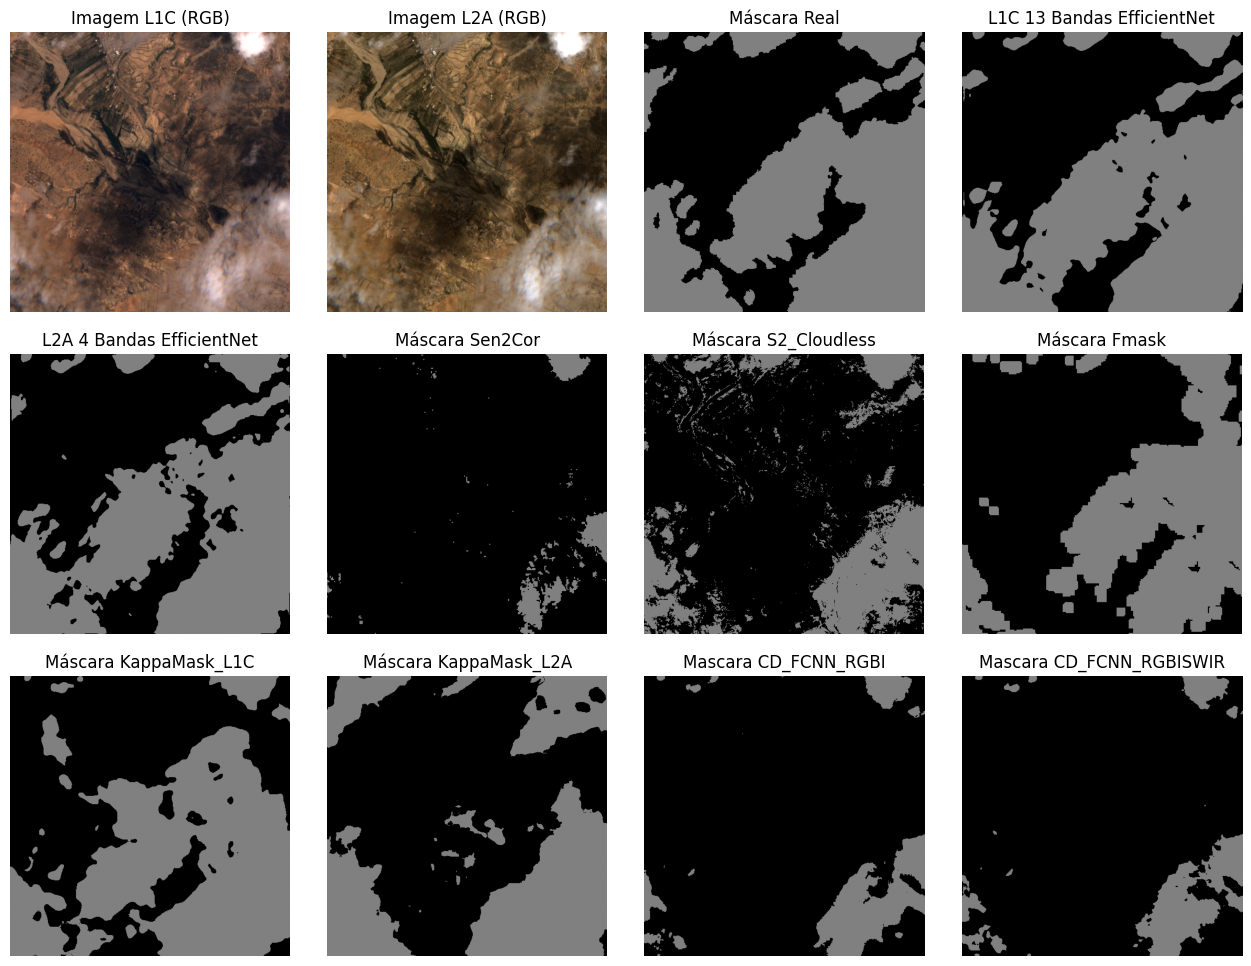

In [99]:
index = index + 1
path = dataset_test.iloc[index]["file_path"]

s2_l1c = path + "/S2L1C.tif"
s2_l2a = path + "/S2L2A.tif"

mask = path + "/labels/manual_hq.tif"
sen2cor = path + "/labels/sen2cor.tif"
s2_cloudless = path + "/labels/s2cloudless.tif"
fmask = path + "/labels/fmask.tif"
kappamask_L1C = path + "/labels/kappamask_L1C.tif"
kappamask_L2A = path + "/labels/kappamask_L2A.tif"
CD_FCNN_RGBI = path +  "/labels/CD-FCNN-RGBI.tif"
CD_FCNN_RGBISWIR = path +  "/labels/CD-FCNN-RGBISWIR.tif"

with rasterio.open(s2_l1c) as s2_l1c_file:
  s2_l1c_data = s2_l1c_file.read().astype(np.float32)/10000

with rasterio.open(s2_l2a) as s2_l2a_file:
  s2_l2a_data = s2_l2a_file.read([2,3,4,8]).astype(np.float32)/10000

model_l1c = load_model(model_l1c_allbands_efficientnet)
l1c_data = pad_image(s2_l1c_data)
mask_l1c = predict(model_l1c, torch.tensor(l1c_data).unsqueeze(0))
mask_l1c = remove_padding(mask_l1c)
mask_l1c[mask_l1c == 2] = 1
mask_l1c[mask_l1c == 3] = 1

model_l2a = load_model(model_l2a_4bands_efficientnet)
l2a_data = pad_image(s2_l2a_data)
mask_l2a = predict(model_l2a, torch.tensor(l2a_data).unsqueeze(0))
mask_l2a = remove_padding(mask_l2a)
mask_l2a[mask_l2a == 2] = 1
mask_l2a[mask_l2a == 3] = 1

with rasterio.open(mask) as mask_file:
  mask_data = mask_file.read(1)
  mask_data[mask_data == 2] = 1
  mask_data[mask_data == 3] = 1

with rasterio.open(sen2cor) as sen2cor_file:
  sen2cor_data = sen2cor_file.read(1)
  # Criando uma cópia dos dados para modificar
  transformed_data = np.zeros_like(sen2cor_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[sen2cor_data == 9] = 1
  transformed_data[sen2cor_data == 8] = 1
  transformed_data[sen2cor_data == 3] = 1
  sen2cor_data = transformed_data

with rasterio.open(s2_cloudless) as s2_cloudless_file:
  s2_cloudless_data = s2_cloudless_file.read(1).astype(np.float32)*0.01
  transformed_data = np.zeros_like(s2_cloudless_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[s2_cloudless_data > 0.4] = 1
  s2_cloudless_data = transformed_data


with rasterio.open(fmask) as fmask_file:
  fmask_data = fmask_file.read(1)
  transformed_data = np.zeros_like(fmask_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[fmask_data == 2] = 1
  transformed_data[fmask_data == 4] = 1
  fmask_data = transformed_data


with rasterio.open(kappamask_L1C) as kappamask_L1C_file:
  kappamask_L1C_data = kappamask_L1C_file.read(1)
  transformed_data = np.zeros_like(kappamask_L1C_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[kappamask_L1C_data == 2] = 1
  transformed_data[kappamask_L1C_data == 3] = 1
  transformed_data[kappamask_L1C_data == 4] = 1
  kappamask_L1C_data = transformed_data


with rasterio.open(kappamask_L2A) as kappamask_L2A_file:
  kappamask_L2A_data = kappamask_L2A_file.read(1)
  transformed_data = np.zeros_like(kappamask_L2A_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[kappamask_L2A_data == 2] = 1
  transformed_data[kappamask_L2A_data == 3] = 1
  transformed_data[kappamask_L2A_data == 4] = 1
  kappamask_L2A_data = transformed_data


with rasterio.open(CD_FCNN_RGBI) as CD_FCNN_RGBI_file:
  CD_FCNN_RGBI_data = CD_FCNN_RGBI_file.read(1).astype(np.float32)*0.0001
  transformed_data = np.zeros_like(CD_FCNN_RGBI_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[CD_FCNN_RGBI_data > 0.5] = 1
  CD_FCNN_RGBI_data = transformed_data


with rasterio.open(CD_FCNN_RGBISWIR) as CD_FCNN_RGBISWIR_file:
  CD_FCNN_RGBISWIR_data = CD_FCNN_RGBISWIR_file.read(1).astype(np.float32)*0.0001
  transformed_data = np.zeros_like(CD_FCNN_RGBISWIR_data)
  # Aplicando as transformações conforme solicitado
  transformed_data[CD_FCNN_RGBISWIR_data > 0.5] = 1
  CD_FCNN_RGBISWIR_data = transformed_data

# Definir as cores (valores de 0 a 3)
cores = ["black", "gray"]
cmap_custom = ListedColormap(cores)

# Criar uma normalização fixa para os valores 0, 1, 2, 3
norm = BoundaryNorm([0, 1, 2], cmap_custom.N)  # Define os intervalos das cores

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Remove espaços entre os subplots para melhor aproveitamento do espaço
plt.subplots_adjust(wspace=0.1, hspace=0.15)

axes[0, 0].imshow(normalize(np.dstack([s2_l1c_data[3], s2_l1c_data[2], s2_l1c_data[1]])))  # RGB falso L1C
axes[0, 0].set_title("Imagem L1C (RGB)")

axes[0, 1].imshow(normalize(np.dstack([s2_l2a_data[2], s2_l2a_data[1], s2_l2a_data[0]])))  # RGB falso L2A
axes[0, 1].set_title("Imagem L2A (RGB)")

axes[0, 2].imshow(mask_data, cmap=cmap_custom, norm=norm)
axes[0, 2].set_title("Máscara Real")

axes[0, 3].imshow(mask_l1c, cmap=cmap_custom, norm=norm)
axes[0, 3].set_title("L1C 13 Bandas EfficientNet")

axes[1, 0].imshow(mask_l2a, cmap=cmap_custom, norm=norm)
axes[1, 0].set_title("L2A 4 Bandas EfficientNet")

axes[1, 1].imshow(sen2cor_data, cmap=cmap_custom, norm=norm)
axes[1, 1].set_title("Máscara Sen2Cor")

axes[1, 2].imshow(s2_cloudless_data, cmap=cmap_custom, norm=norm)
axes[1, 2].set_title("Máscara S2_Cloudless")

axes[1, 3].imshow(fmask_data, cmap=cmap_custom, norm=norm)
axes[1, 3].set_title("Máscara Fmask")

axes[2, 0].imshow(kappamask_L1C_data, cmap=cmap_custom, norm=norm)
axes[2, 0].set_title("Máscara KappaMask_L1C")

axes[2, 1].imshow(kappamask_L2A_data, cmap=cmap_custom, norm=norm)
axes[2, 1].set_title("Máscara KappaMask_L2A")

axes[2, 2].imshow(CD_FCNN_RGBI_data, cmap=cmap_custom, norm=norm)
axes[2, 2].set_title("Mascara CD_FCNN_RGBI")

axes[2, 3].imshow(CD_FCNN_RGBISWIR_data, cmap=cmap_custom, norm=norm)
axes[2, 3].set_title("Mascara CD_FCNN_RGBISWIR")

# Removendo números dos eixos e bordas desnecessárias
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Salvando em alta resolução com bordas mínimas
plt.savefig("comparação_modelos_valido_invalido5.png", dpi=600, bbox_inches='tight')
plt.show()